This dataset is a large-scale dataset for news recommendation research.It was collected by Microsoft from Microsoft News website. It contains about 160k English news articles and more than 15 million impression logs generated by 1 million users. Every news article contains rich textual content including title, abstract, body, category and entities. Each impression log contains the click events, non-clicked events and historical news click behaviors of this user before this impression.
 
To protect user privacy, each user was de-linked from the production system when securely hashed into an anonymized ID. 



In [4]:
import sys
sys.path.append("../../")
import os
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import scrapbook as sb
from tempfile import TemporaryDirectory
import tensorflow as tf
import pandas as pd
import altair as alt
tf.get_logger().setLevel('ERROR') # only show error messages
from utils import download_deeprec_resources 
from utils import get_mind_data_set

First we download the dataset and show the structure of the data.

In [5]:
MIND_type = 'demo'

tmpdir = TemporaryDirectory()
data_path = tmpdir.name

train_news_file = os.path.join(data_path, 'train', r'news.tsv')
train_behaviors_file = os.path.join(data_path, 'train', r'behaviors.tsv')
valid_news_file = os.path.join(data_path, 'valid', r'news.tsv')
valid_behaviors_file = os.path.join(data_path, 'valid', r'behaviors.tsv')
wordEmb_file = os.path.join(data_path, "utils", "embedding.npy")
userDict_file = os.path.join(data_path, "utils", "uid2index.pkl")
wordDict_file = os.path.join(data_path, "utils", "word_dict.pkl")
yaml_file = os.path.join(data_path, "utils", r'nrms.yaml')

mind_url, mind_train_dataset, mind_dev_dataset, mind_utils = get_mind_data_set(MIND_type)

if not os.path.exists(train_news_file):
    download_deeprec_resources(mind_url, os.path.join(data_path, 'train'), mind_train_dataset)
    
if not os.path.exists(valid_news_file):
    download_deeprec_resources(mind_url, \
                               os.path.join(data_path, 'valid'), mind_dev_dataset)
if not os.path.exists(yaml_file):
    download_deeprec_resources(r'https://recodatasets.z20.web.core.windows.net/newsrec/', \
                               os.path.join(data_path, 'utils'), mind_utils)

100%|██████████| 17.0k/17.0k [00:07<00:00, 2.16kKB/s]
100%|██████████| 9.84k/9.84k [00:00<00:00, 11.5kKB/s]
100%|██████████| 95.0k/95.0k [00:04<00:00, 22.8kKB/s]


In [6]:
news = pd.read_table(os.path.join(data_path, 'train', 'news.tsv'),
                     names=['newid', 'vertical', 'subvertical', 'title',
                            'abstract', 'url', 'entities in title', 'entities in abstract'])

The folllowing shows the first five entries of the News data.

In [7]:
news.head()

,newid,vertical,subvertical,title,abstract,url,entities in title,entities in abstract
0,N3112,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://www.msn.com/en-us/lifestyle/lifestyler...,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N10399,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://www.msn.com/en-us/news/world/the-cost-...,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
2,N12103,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://www.msn.com/en-us/health/voices/i-was-...,[],"[{""Label"": ""National Basketball Association"", ..."
3,N20460,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://www.msn.com/en-us/health/medical/how-t...,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
4,N5409,weather,weathertopstories,It's been Orlando's hottest October ever so fa...,There won't be a chill down to your bones this...,https://www.msn.com/en-us/weather/weathertopst...,"[{""Label"": ""Orlando, Florida"", ""Type"": ""G"", ""W...","[{""Label"": ""Orlando, Florida"", ""Type"": ""G"", ""W..."


Here is an example of news. 

In [8]:
news.loc[20]

newid                                                              N27958
vertical                                                           sports
subvertical                                                basketball_nba
title                   LA rivalry takes on new meaning for fans as La...
abstract                NBA Finals MVP Kawhi Leonard and other Clipper...
url                     https://www.msn.com/en-us/sports/basketball_nb...
entities in title       [{"Label": "Los Angeles Clippers", "Type": "O"...
entities in abstract    [{"Label": "Los Angeles Clippers", "Type": "O"...
Name: 20, dtype: object

Next, we show the users behavior data.

In [10]:
Behavior=pd.read_table(os.path.join(data_path, 'train', 'behaviors.tsv'),
                       names= ["Impression ID", "User ID", "Impression Time", "User Click History", "Impression News"])

The below block shows the first five entries of the user behaivor data. It contains ID, time, user click history , impression news. 

In [11]:
Behavior.head()



,Impression ID,User ID,Impression Time,User Click History,Impression News
0,1,U82271,11/11/2019 3:28:58 PM,N3130 N11621 N12917 N4574 N12140 N9748,N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...
1,2,U84185,11/12/2019 10:36:47 AM,N27209 N11723 N4617 N12320 N11333 N24461 N2211...,N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...
2,3,U11552,11/11/2019 1:03:52 PM,N2139,N18390-0 N10537-0 N23967-1
3,4,U68381,11/11/2019 6:44:05 AM,N27420 N11621 N25416 N25457 N5124 N11751 N1175...,N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...
4,5,U52303,11/12/2019 3:11:52 AM,N1332 N12667,N15645-0 N7911-1


In [12]:
Behavior.loc[1][4]

'N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1132-0 N13649-0'

If the Impreesion news end with 0 then the user didn't click that news. If the impression news end with 1 then the user clicked that news. 

In [13]:
Behavior["User Click History"]=  pd.Series(Behavior["User Click History"].str.split(" "))
Behavior["Impression News"]=pd.Series( Behavior["Impression News"].str.split(" "))
Behavior["history_l"]=Behavior["User Click History"].str.len()
Behavior["impression_l"]=Behavior["Impression News"].str.len()

click=[]
total=[]
for index, row in Behavior.iterrows():
    count=0
    total.append(len(row["Impression News"]))
    for ele in row["Impression News"]:             
        count+=ele.endswith("-1")
    click.append(count)
Behavior["click"]=click
Behavior["total"]=total
Behavior["ratio"]=Behavior["click"]/Behavior["total"]

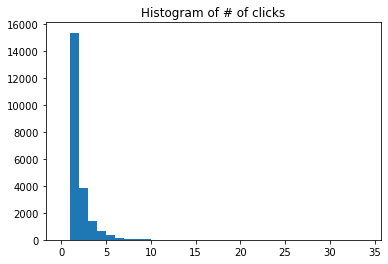

In [14]:
maxi = max(Behavior["click"])
bins = range(0, maxi)
plt.hist(Behavior["click"],bins=bins)
plt.title('Histogram of # of clicks')
plt.show() 

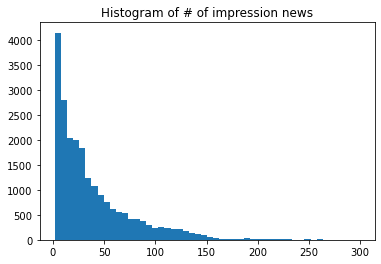

In [15]:
maxi = max(Behavior["total"])
bins = range(0, maxi)
plt.hist(Behavior["total"],50)
plt.title('Histogram of # of impression news')
plt.show() 

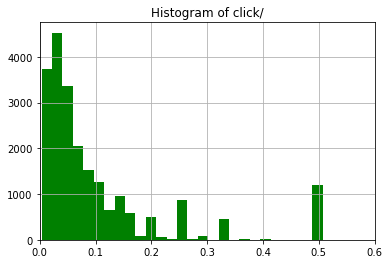

In [16]:
plt.hist(Behavior["ratio"],40,facecolor='g')
plt.xlim(0,0.6)
plt.grid(True)
plt.title('Histogram of click/')
plt.show() 

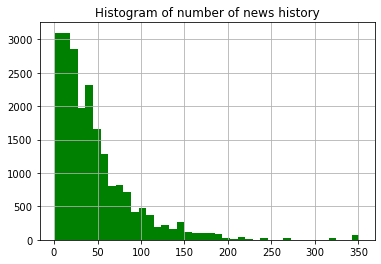

In [17]:
plt.hist(Behavior["history_l"],40,facecolor='g')
# plt.xlim(0,0.6)
plt.grid(True)
plt.title('Histogram of number of news history')
plt.show() 

Then, we clean the data and fit the movie recommendation model we learned this quarter. 

In [18]:
Behavior.rename(columns={"User Click History": "history"},inplace=True)

In [22]:
emp=[]
for l in Behavior.history:
    if not isinstance(l, float):
        for ele in l:
            emp.append(ele)
col=set(emp)
col=list(col)

In [23]:
for ele in col:
    Behavior[ele]=0

In [24]:
for i, row in Behavior.iterrows():
#     print(i)
    c=row['history']
    if not isinstance(c, float):
        for ele in c:
            Behavior.at[i,ele]=1

In [25]:
lec=Behavior.drop(["User ID","Impression ID","Impression Time","history","history_l","impression_l","click",'total',"Impression News","ratio"],axis=1)


In [26]:
I = 16
M = 15

# retrieve movies/users combination that is not *too* sparse
top_news = lec.agg(sum, axis=0).nlargest(200).tail(I).index
top_user = lec.agg(sum, axis=1).nlargest(200).tail(M).index

In [27]:
top_user

Int64Index([ 1535,  1792, 11020, 11909, 12073, 13182, 15176, 15627,  1172,
             2070,  2293,  2474,  2549,  7202,  8019],
           dtype='int64')

In [28]:
R = lec.loc[top_user, top_news]

In [29]:
R

,N21768,N1055,N1268,N11938,N27079,N23739,N5273,N13944,N11693,N28442,N20332,N17468,N15044,N8741,N27700,N16836
1535,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1792,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
11020,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
11909,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
12073,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
13182,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
15176,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
15627,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1172,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0
2070,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0


In [41]:
I = 16 # number of users
M = 15 # number of movies
K = 5  # number of latent factors

# initialize U and V with random values
np.random.seed(42)

U = np.random.uniform(0, 1, size=K*I).reshape((I, K))
V = np.random.uniform(0, 1, size=K*M).reshape((M, K))

Uold = np.zeros_like(U)
Vold = np.zeros_like(V)

In [42]:
def rmse(X, Y):
    from numpy import sqrt, nanmean
    return sqrt(nanmean((X - Y)**2))

error = [(0, rmse(R, np.inner(V,U)))]

# calculate maximum magnitude of relative updates
def max_update(X, Y):
    from numpy import inf
    from numpy.linalg import norm
    return norm(((X - Y)/Y).ravel(), inf)

update = [(0, max(max_update(Uold, U), max_update(Vold, V)))]

In [43]:
rate = 0.1            # learning rate (step size) 
max_iterations = 1500  # maximum number of iterations
threshold = 0.001     # max_update threshold for termination

for t in range(1, max_iterations):
     
    for m, i in zip(*np.where(~np.isnan(R))):
        
        U[i] = U[i] + rate*V[m]*(R.iloc[m,i] - np.inner(V[m], U[i]))
        V[m] = V[m] + rate*U[i]*(R.iloc[m,i] - np.inner(V[m], U[i]))
        
    # compute error after one sweep of updates
    error += [(t, rmse(R, np.inner(V,U)))]
    
    # keep track of how much U and V changes
    update += [(t, max(max_update(Uold, U), max_update(Vold, V)))]
    Uold = U.copy()
    Vold = V.copy()
    
error = pd.DataFrame(error, columns=['iteration', 'rmse'])
update = pd.DataFrame(update , columns=['iteration', 'maximum update'])

In [44]:
update

,iteration,maximum update
0,0,1.000000e+00
1,1,1.000000e+00
2,2,8.483256e+00
3,3,6.939006e+02
4,4,2.939950e+00
...,...,...
1495,1495,8.457910e-12
1496,1496,8.323303e-12
1497,1497,8.189676e-12
1498,1498,8.058404e-12


In [45]:
error

,iteration,rmse
0,0,1.097657e+00
1,1,3.246823e-01
2,2,2.703404e-01
3,3,2.451691e-01
4,4,2.224441e-01
...,...,...
1495,1495,2.294029e-13
1496,1496,2.256955e-13
1497,1497,2.220501e-13
1498,1498,2.184641e-13


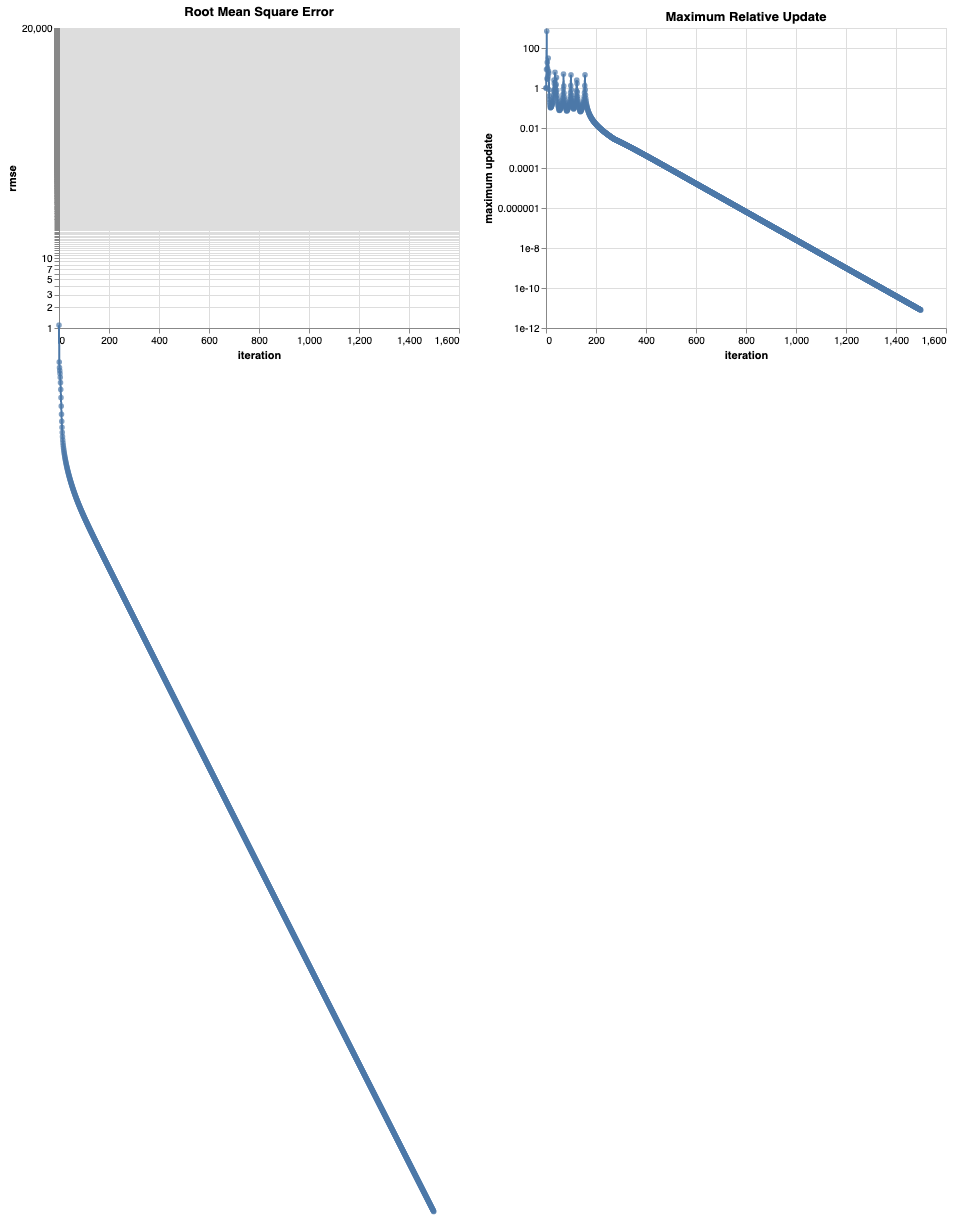

In [46]:
f_rmse = alt.Chart(error).encode(x='iteration:Q', y=alt.Y('rmse:Q', scale=alt.Scale(type='log', base=20000, domain=[1,2])))
f_update = alt.Chart(update).encode(x='iteration:Q', y=alt.Y('maximum update:Q', scale=alt.Scale(type='log', base=10)))

alt.hconcat(
    alt.layer(f_rmse.mark_line(), f_rmse.mark_point(filled=True), title='Root Mean Square Error'),
    alt.layer(f_update.mark_line(), f_update.mark_point(filled=True), title='Maximum Relative Update')
)

In [47]:
Rone = R.copy()
Rone.loc[:,:] = 1 # easiest way to copy over row/column names
Rhat = np.inner(V, U) * Rone
Rhat_if_obs = Rhat.where(~np.isnan(R), np.nan)

# R_compare = \
#     R.rename(columns={'rating':'observed'})\
#     .join(Rhat_if_obs.rename(columns={'rating':'fit'}))\
#     .join(Rhat.rename(columns={'rating':'fit/prediction'}))\
#     .join((Rhat_if_obs-R).rename(columns={'rating':'deviation'}))

# long(R_compare)

In [48]:
R

,N21768,N1055,N1268,N11938,N27079,N23739,N5273,N13944,N11693,N28442,N20332,N17468,N15044,N8741,N27700,N16836
1535,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1792,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
11020,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
11909,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
12073,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
13182,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
15176,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
15627,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1172,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0
2070,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0


In [49]:
Rhat

,N21768,N1055,N1268,N11938,N27079,N23739,N5273,N13944,N11693,N28442,N20332,N17468,N15044,N8741,N27700,N16836
1535,5.944874e-14,-2.421986e-13,1.281200e-16,-5.366695e-13,2.709663e-13,-3.384220e-15,4.969551e-13,3.916171e-13,1.0,-2.908377e-13,-5.875460e-13,5.987633e-13,-6.683056e-13,1.000000e+00,5.498550e-14,-1.467512e-13
1792,-2.838658e-14,1.150101e-13,-2.978620e-16,2.546936e-13,-1.284772e-13,1.268334e-15,-2.358974e-13,-1.864328e-13,1.0,1.374677e-13,2.782191e-13,-2.840022e-13,3.170102e-13,1.000000e+00,-2.595672e-14,6.948452e-14
11020,-5.186544e-15,2.077282e-14,-2.931418e-16,4.619355e-14,-2.326968e-14,1.514576e-17,-4.263227e-14,-3.394452e-14,1.0,2.469365e-14,5.021822e-14,-5.151477e-14,5.732127e-14,1.000000e+00,-4.406444e-15,1.271975e-14
11909,1.723617e-14,-7.015412e-14,-2.685464e-17,-1.555068e-13,7.859473e-14,-1.005046e-15,1.440482e-13,1.132679e-13,1.0,-8.450741e-14,-1.704970e-13,1.735858e-13,-1.937198e-13,1.000000e+00,1.617750e-14,-4.255524e-14
12073,3.408892e-14,-1.391712e-13,2.211580e-17,-3.088087e-13,1.560664e-13,-1.923545e-15,2.859112e-13,2.251373e-13,1.0,-1.675056e-13,-3.382556e-13,3.447892e-13,-3.844532e-13,1.000000e+00,3.167727e-14,-8.465516e-14
13182,-3.435829e-14,1.398762e-13,-2.251656e-16,3.096478e-13,-1.561637e-13,1.804807e-15,-2.867477e-13,-2.265264e-13,1.0,1.672417e-13,3.383901e-13,-3.452063e-13,3.854884e-13,1.000000e+00,-3.130660e-14,8.447334e-14
15176,-5.689203e-14,2.314937e-13,-4.867547e-16,5.132653e-13,-2.590704e-13,2.818939e-15,-4.750889e-13,-3.749953e-13,1.0,2.775086e-13,5.612298e-13,-5.726404e-13,6.387785e-13,1.000000e+00,-5.202428e-14,1.404817e-13
15627,3.029462e-14,-1.229508e-13,9.535490e-18,-2.721550e-13,1.374232e-13,-1.677267e-15,2.522253e-13,1.986401e-13,1.0,-1.476071e-13,-2.980327e-13,3.035861e-13,-3.390883e-13,1.000000e+00,2.830645e-14,-7.422275e-14
1172,1.000000e+00,-1.097563e-14,1.000000e+00,-2.459451e-14,1.233015e-14,1.000000e+00,2.242010e-14,1.791496e-14,1.0,-1.307679e-14,-2.670150e-14,2.748989e-14,-3.035069e-14,3.958137e-15,1.000000e+00,-7.003868e-15
2070,1.000000e+00,1.155325e-13,1.000000e+00,2.556914e-13,-1.290312e-13,1.000000e+00,-2.366934e-13,-1.864026e-13,1.0,1.388374e-13,2.802181e-13,-2.850455e-13,3.186137e-13,-4.394903e-14,1.000000e+00,6.983661e-14


In [50]:
Rhat_if_obs

,N21768,N1055,N1268,N11938,N27079,N23739,N5273,N13944,N11693,N28442,N20332,N17468,N15044,N8741,N27700,N16836
1535,5.944874e-14,-2.421986e-13,1.281200e-16,-5.366695e-13,2.709663e-13,-3.384220e-15,4.969551e-13,3.916171e-13,1.0,-2.908377e-13,-5.875460e-13,5.987633e-13,-6.683056e-13,1.000000e+00,5.498550e-14,-1.467512e-13
1792,-2.838658e-14,1.150101e-13,-2.978620e-16,2.546936e-13,-1.284772e-13,1.268334e-15,-2.358974e-13,-1.864328e-13,1.0,1.374677e-13,2.782191e-13,-2.840022e-13,3.170102e-13,1.000000e+00,-2.595672e-14,6.948452e-14
11020,-5.186544e-15,2.077282e-14,-2.931418e-16,4.619355e-14,-2.326968e-14,1.514576e-17,-4.263227e-14,-3.394452e-14,1.0,2.469365e-14,5.021822e-14,-5.151477e-14,5.732127e-14,1.000000e+00,-4.406444e-15,1.271975e-14
11909,1.723617e-14,-7.015412e-14,-2.685464e-17,-1.555068e-13,7.859473e-14,-1.005046e-15,1.440482e-13,1.132679e-13,1.0,-8.450741e-14,-1.704970e-13,1.735858e-13,-1.937198e-13,1.000000e+00,1.617750e-14,-4.255524e-14
12073,3.408892e-14,-1.391712e-13,2.211580e-17,-3.088087e-13,1.560664e-13,-1.923545e-15,2.859112e-13,2.251373e-13,1.0,-1.675056e-13,-3.382556e-13,3.447892e-13,-3.844532e-13,1.000000e+00,3.167727e-14,-8.465516e-14
13182,-3.435829e-14,1.398762e-13,-2.251656e-16,3.096478e-13,-1.561637e-13,1.804807e-15,-2.867477e-13,-2.265264e-13,1.0,1.672417e-13,3.383901e-13,-3.452063e-13,3.854884e-13,1.000000e+00,-3.130660e-14,8.447334e-14
15176,-5.689203e-14,2.314937e-13,-4.867547e-16,5.132653e-13,-2.590704e-13,2.818939e-15,-4.750889e-13,-3.749953e-13,1.0,2.775086e-13,5.612298e-13,-5.726404e-13,6.387785e-13,1.000000e+00,-5.202428e-14,1.404817e-13
15627,3.029462e-14,-1.229508e-13,9.535490e-18,-2.721550e-13,1.374232e-13,-1.677267e-15,2.522253e-13,1.986401e-13,1.0,-1.476071e-13,-2.980327e-13,3.035861e-13,-3.390883e-13,1.000000e+00,2.830645e-14,-7.422275e-14
1172,1.000000e+00,-1.097563e-14,1.000000e+00,-2.459451e-14,1.233015e-14,1.000000e+00,2.242010e-14,1.791496e-14,1.0,-1.307679e-14,-2.670150e-14,2.748989e-14,-3.035069e-14,3.958137e-15,1.000000e+00,-7.003868e-15
2070,1.000000e+00,1.155325e-13,1.000000e+00,2.556914e-13,-1.290312e-13,1.000000e+00,-2.366934e-13,-1.864026e-13,1.0,1.388374e-13,2.802181e-13,-2.850455e-13,3.186137e-13,-4.394903e-14,1.000000e+00,6.983661e-14
